In [30]:
from pathlib import Path
import os

# Establece la raíz del proyecto manualmente
project_root = Path("F:/JCMDataCenter/Cursos/Evolve Academy/Data Scientist IA/Futpeak") # sobremesa
#project_root = Path("C:/Users/juanm/Desktop/FUTPEAK/Futpeak") # portátil

# Cambia el directorio de trabajo actual a esa raíz
os.chdir(project_root)

print("📁 Directorio de trabajo actual:", Path.cwd())

📁 Directorio de trabajo actual: F:\JCMDataCenter\Cursos\Evolve Academy\Data Scientist IA\Futpeak


# ETAPA 1 — Carga y exploración de los datos

En esta primera etapa, cargamos los archivos `matchlogs` y `metadata`, que contienen información por partido y por jugador, respectivamente.

Nuestro objetivo aquí no es solo cargar los datos, sino **entender qué columnas hay, qué tipo de variables contiene cada una, y cuáles vamos a usar o descartar**.

### ¿Qué buscamos al explorar?
- Qué columnas tienen valores nulos
- Qué columnas son categóricas, numéricas o de fecha
- Si hay identificadores únicos (`Player_ID`)
- Qué variables nos pueden servir para el modelo

Vamos a centrarnos en **variables relacionadas con el rendimiento en el campo**, y **descartar muchas otras que no aportan directamente al objetivo de predecir la evolución del jugador**.



In [31]:
import pandas as pd

# Load datasets
df_matchlogs = pd.read_csv("data/processed/cleaned_matchlogs.csv")
df_metadata = pd.read_csv("data/processed/cleaned_metadata.csv")

# Show general info for structure
print("🔍 Matchlogs structure:")
df_matchlogs.info()

print("\n🧾 Metadata structure:")
df_metadata.info()

# Preview a few rows
df_matchlogs.head()


🔍 Matchlogs structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368257 entries, 0 to 368256
Data columns (total 46 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Player_name            368257 non-null  object 
 1   Player_ID              368257 non-null  object 
 2   Seasons                368257 non-null  object 
 3   Date                   368257 non-null  object 
 4   Day                    368257 non-null  object 
 5   Competition            368257 non-null  object 
 6   Round                  368257 non-null  object 
 7   Home_Away              368257 non-null  object 
 8   Result                 368257 non-null  object 
 9   Player_team            368257 non-null  object 
 10  Rival_team             368257 non-null  object 
 11  Start                  368257 non-null  object 
 12  Position               283886 non-null  object 
 13  Minutes                367852 non-null  float64
 14  Goals        

,Player_name,Player_ID,Seasons,Date,Day,Competition,Round,Home_Away,Result,Player_team,...,x_assisted_G,Shot_creating_actions,Goal_creating_actions,Passes_completed,Passes_att,Percent_passes,Progressive_passes,Feet_control,Progressive_control,Dribling_suc
0,Luciano Abecasis,6c510f2d,2016,2016-02-05,Fri,Primera Div,Matchweek 1,Away,L 0–1,Godoy Cruz,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Luciano Abecasis,6c510f2d,2016,2016-02-12,Fri,Primera Div,Matchweek 2,Home,D 1–1,Godoy Cruz,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Luciano Abecasis,6c510f2d,2016,2016-02-18,Thu,Primera Div,Matchweek 3,Away,W 2–1,Godoy Cruz,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Luciano Abecasis,6c510f2d,2016,2016-02-21,Sun,Primera Div,Matchweek 4,Home,W 4–1,Godoy Cruz,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Luciano Abecasis,6c510f2d,2016,2016-02-26,Fri,Primera Div,Matchweek 5,Away,W 3–2,Godoy Cruz,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# View all columns in matchlogs
print("🔧 All columns in matchlogs:")
print(df_matchlogs.columns.tolist())

# List of columns we plan to keep
columns_to_use = [
    'Player_ID', 'Date', 'Minutes', 'Goals', 'Assists',
    'Shots', 'Shots_on_target', 'Yellow_cards', 'Red_cards'
]

print("\n✅ Columns selected for modeling:")
print(columns_to_use)

# Optional: create a reduced version of the matchlogs
df_matchlogs = df_matchlogs[columns_to_use]



🔧 All columns in matchlogs:
['Player_name', 'Player_ID', 'Seasons', 'Date', 'Day', 'Competition', 'Round', 'Home_Away', 'Result', 'Player_team', 'Rival_team', 'Start', 'Position', 'Minutes', 'Goals', 'Assists', 'Penalty_kick', 'Penalty_kick_att', 'Shots', 'Shots_on_target', 'Yellow_cards', 'Red_cards', 'Fouls_committed', 'Fouls_drawn', 'Offsides', 'Crosses', 'Tackles_won', 'Interceptions', 'Own_goals', 'Penaltys_won', 'Penaltys_conceded', 'Touches', 'Tackles', 'Blocks', 'xG', 'non_penalty_xG', 'x_assisted_G', 'Shot_creating_actions', 'Goal_creating_actions', 'Passes_completed', 'Passes_att', 'Percent_passes', 'Progressive_passes', 'Feet_control', 'Progressive_control', 'Dribling_suc']

✅ Columns selected for modeling:
['Player_ID', 'Date', 'Minutes', 'Goals', 'Assists', 'Shots', 'Shots_on_target', 'Yellow_cards', 'Red_cards']


# ETAPA 2 — Filtrado de jugadores ofensivos y cálculo del debut

No todos los jugadores tienen el mismo tipo de rendimiento ni las mismas estadísticas.  
En este proyecto, **nos centramos en jugadores ofensivos y mediocampistas**, porque son los que aportan goles, asistencias y tiros (las métricas que usaremos para valorar el rendimiento).

Además, para poder analizar la progresión desde el inicio de la carrera, necesitamos:
- Detectar el **primer partido profesional (debut)**.
- Calcular desde entonces en qué año de carrera está cada jugador en cada partido.

También calcularemos la edad del jugador en cada partido, porque **la edad es una variable predictiva clave** para el tipo de evolución que tendrá.


In [33]:
POSITION_GROUPS = {
    'GOALKEEPER': ['GK'],

    'DEFENSIVE': [
        'CB',    # Center Back
        'LB',    # Left Back
        'RB',    # Right Back
        'FB',    # Fullback
        'LWB',   # Left Wing Back
        'RWB',   # Right Wing Back
        'SW',    # Sweeper
        'D'      # Generic Defender
    ],

    'MIDFIELD': [
        'CM',    # Center Midfielder
        'DM',    # Defensive Midfielder
        'MF',     # Generic Midfielder
        'AM'     # Attacking Midfielder (can also be attacking, but here consider control of juego)
    ],

    'ATTACKING': [
        'CF',    # Center Forward
        'ST',    # Striker
        'F',     # Generic Forward
        'FW',    # Forward (alternative code)
        'LW',    # Left Wing
        'RW',    # Right Wing
        'WF',    # Wing Forward
        'IF',    # Inside Forward
        'OL',    # Outside Left
        'OR'     # Outside Right
    ]
}


In [34]:
# Define relevant positions for attacking/midfield players
target_positions = POSITION_GROUPS['MIDFIELD'] + POSITION_GROUPS['ATTACKING']

# Create a function to check if position is relevant
def is_target_position(pos):
    if pd.isna(pos):
        return False
    return any(p in pos.split('-') for p in target_positions)

# Filter metadata to only include target players
df_metadata['Is_Target'] = df_metadata['Position'].apply(is_target_position)
df_metadata_target = df_metadata[df_metadata['Is_Target']]

# Filter matchlogs for selected players
target_ids = df_metadata_target['Player_ID'].unique()
df_matchlogs_target = df_matchlogs[df_matchlogs['Player_ID'].isin(target_ids)].copy()


In [35]:
# Convert Date columns to datetime
df_matchlogs_target['Date'] = pd.to_datetime(df_matchlogs_target['Date'], errors='coerce')
df_metadata['Birth_date'] = pd.to_datetime(df_metadata['Birth_date'], errors='coerce')

# Merge Birth_date into matchlogs
df_matchlogs_target = df_matchlogs_target.merge(
    df_metadata[['Player_ID', 'Birth_date']],
    on='Player_ID', how='left'
)

# Calcular debut por jugador (primer partido con minutos > 0)
debut_dates = df_matchlogs_target[df_matchlogs_target['Minutes'] > 0].groupby('Player_ID')['Date'].min()
df_matchlogs_target['Debut_date'] = df_matchlogs_target['Player_ID'].map(debut_dates)

# Calcular año relativo desde el debut
df_matchlogs_target['year_since_debut'] = (
    (df_matchlogs_target['Date'] - df_matchlogs_target['Debut_date']).dt.days // 365 + 1
)

# Calcular edad en el partido
df_matchlogs_target['age'] = (
    (df_matchlogs_target['Date'] - df_matchlogs_target['Birth_date']).dt.days / 365.25
)


# ETAPA 3 — Cálculo del rendimiento ofensivo por partido

Queremos transformar las estadísticas individuales (goles, asistencias, tiros, tarjetas...) en **una única métrica de rendimiento**.  
Esta métrica nos permitirá comparar partidos entre sí de manera más objetiva.

Además, vamos a normalizar esta métrica por 90 minutos.  
¿Por qué? Porque jugar 15 minutos y marcar un gol no equivale a jugar 90 y marcar uno. **Necesitamos ajustar el rendimiento al tiempo jugado.**

### Fórmula propuesta:
- +5 por cada gol
- +4 por asistencia
- +0.5 por tiro a puerta
- +0.1 por tiro fuera
- -1 por amarilla
- -2 por roja

El resultado se divide por los minutos jugados y se multiplica por 90 → rendimiento por 90 minutos.


In [36]:
# Fill missing values with 0
cols = ['Goals', 'Assists', 'Shots', 'Shots_on_target', 'Yellow_cards', 'Red_cards', 'Minutes']
df_matchlogs_target[cols] = df_matchlogs_target[cols].fillna(0)

# Function to compute performance rating
def calculate_rating(row):
    score = (
        row['Goals'] * 5 +
        row['Assists'] * 4 +
        row['Shots_on_target'] * 0.5 +
        (row['Shots'] - row['Shots_on_target']) * 0.1 -
        row['Yellow_cards'] * 1 -
        row['Red_cards'] * 2
    )
    return score / (row['Minutes'] / 90) if row['Minutes'] > 0 else 0

# Apply to dataset
df_matchlogs_target['rating_per_90'] = df_matchlogs_target.apply(calculate_rating, axis=1)


# ETAPA 4 — Agregación por año y creación de la trayectoria del jugador

Ahora que ya tenemos el rendimiento de cada partido (`rating_per_90`), necesitamos pasar de datos por partido a **una vista por año** desde el debut.

### ¿Por qué agregamos por año?
Porque queremos ver cómo evoluciona el jugador en su carrera. Si analizamos partido por partido, hay demasiado ruido.

### ¿Qué vamos a calcular por jugador y año?
- Minutos totales jugados
- Goles totales
- Asistencias totales
- Media de `rating_per_90` del año
- Edad promedio ese año

Este dataset será nuestra "foto" anual del jugador, y servirá para modelar su evolución.


In [37]:
# Group by player and year since debut
career_df = df_matchlogs_target.groupby(['Player_ID', 'year_since_debut']).agg({
    'Minutes': 'sum',
    'Goals': 'sum',
    'Assists': 'sum',
    'rating_per_90': 'mean',
    'age': 'mean'  # Edad promedio ese año
}).reset_index()


# ETAPA 5 — Detección del año de pico y clasificación de tipo de carrera

Para predecir cómo será la evolución de un jugador, primero tenemos que saber **cómo fue la de los jugadores históricos**.

Aquí vamos a:
1. Detectar el **año de pico** de cada jugador, es decir, el año en el que tuvo su mejor rendimiento (`rating_per_90`).
2. Clasificar ese año como:
   - `temprano` si ocurrió en los primeros 2 años
   - `medio` si ocurrió entre los años 3 y 4
   - `tardío` si ocurrió en el año 5 o más

Esto se convertirá en nuestra **variable objetivo (`target`)**. Es lo que el modelo intentará predecir.

Además, filtraremos los años con muy pocos minutos jugados, ya que pueden dar lugar a "falsos picos".


In [38]:
# Filtrar años con suficiente tiempo jugado (evita picos engañosos)
valid_seasons = career_df[career_df['Minutes'] >= 300]

# Buscar el año con mejor rating por jugador
peak_info = (
    valid_seasons.sort_values(['Player_ID', 'rating_per_90'], ascending=[True, False])
    .groupby('Player_ID')
    .first()
    .reset_index()
    .rename(columns={'year_since_debut': 'peak_year', 'rating_per_90': 'peak_rating'})
)

# Unir esta info a la trayectoria completa
career_with_peak = career_df.merge(
    peak_info[['Player_ID', 'peak_year', 'peak_rating']],
    on='Player_ID', how='left'
)


In [39]:
# ETAPA 6 — Preparación del dataset de entrenamiento (corregida binaria, sin fugas)

# Por si acaso la columna target no está
if 'target' not in career_with_peak.columns:
    career_with_peak['target'] = career_with_peak['peak_year'].apply(lambda x: 1 if x <= 3 else 0)

# Usamos SOLO los primeros 3 años
early_years = career_with_peak[career_with_peak['year_since_debut'] <= 3]

# Pivot
pivot_rating = early_years.pivot(index='Player_ID', columns='year_since_debut', values='rating_per_90')
pivot_age = early_years.pivot(index='Player_ID', columns='year_since_debut', values='age')
pivot_minutes = early_years.pivot(index='Player_ID', columns='year_since_debut', values='Minutes')

# Renombrar
pivot_rating.columns = [f'rating_year_{i}' for i in pivot_rating.columns]
pivot_age.columns = [f'age_year_{i}' for i in pivot_age.columns]
pivot_minutes.columns = [f'minutes_year_{i}' for i in pivot_minutes.columns]

# Combinar
pivot_combined = pd.concat([pivot_rating, pivot_age, pivot_minutes], axis=1).fillna(0)

# Nuevas features solo hasta año 3
pivot_combined['growth_2_1'] = pivot_combined['rating_year_2'] - pivot_combined['rating_year_1']
pivot_combined['growth_3_2'] = pivot_combined['rating_year_3'] - pivot_combined['rating_year_2']
pivot_combined['avg_rating'] = pivot_combined[[f'rating_year_{i}' for i in range(1, 4)]].mean(axis=1)
pivot_combined['rating_std'] = pivot_combined[[f'rating_year_{i}' for i in range(1, 4)]].std(axis=1)
pivot_combined['avg_age'] = pivot_combined[[f'age_year_{i}' for i in range(1, 4)]].mean(axis=1)
pivot_combined['sum_minutes'] = pivot_combined[[f'minutes_year_{i}' for i in range(1, 4)]].sum(axis=1)

# Merge con target binario
model_df = pivot_combined.merge(
    career_with_peak[['Player_ID', 'target']],
    on='Player_ID',
    how='inner'
)


In [40]:
# ETAPA 7 — Preparación de los datos para entrenamiento (sin fuga, split por jugador)

from sklearn.model_selection import train_test_split

feature_cols = [
    'rating_year_1', 'rating_year_2', 'rating_year_3',
    'growth_2_1', 'growth_3_2',
    'avg_rating', 'rating_std',
    'age_year_1', 'age_year_2', 'age_year_3', 'avg_age',
    'minutes_year_1', 'minutes_year_2', 'minutes_year_3', 'sum_minutes'
]

# Asegurar que Player_ID está como columna y no se pierde
model_df = model_df.reset_index(drop=True)

X = model_df[feature_cols]
y = model_df['target']
player_ids = model_df['Player_ID']


unique_ids = player_ids.unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)

train_df = model_df[model_df['Player_ID'].isin(train_ids)]
test_df = model_df[model_df['Player_ID'].isin(test_ids)]

X_train = train_df[feature_cols]
y_train = train_df['target']
X_test = test_df[feature_cols]
y_test = test_df['target']


✅ Accuracy: 0.797 | Kappa: 0.299 | MCC: 0.299

📋 Classification Report:
              precision    recall  f1-score   support

      Maduro       0.88      0.88      0.88      1931
    Temprano       0.42      0.43      0.42       406

    accuracy                           0.80      2337
   macro avg       0.65      0.65      0.65      2337
weighted avg       0.80      0.80      0.80      2337



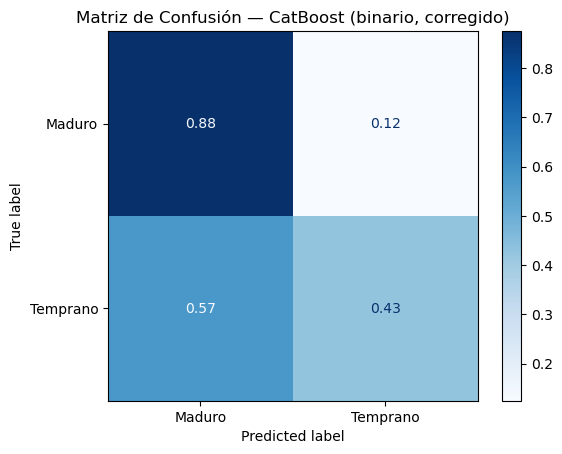

In [41]:
# ETAPA 8 — Entrenamiento del modelo CatBoost y evaluación binaria

from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, cohen_kappa_score, matthews_corrcoef,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import numpy as np

# Calcular pesos balanceados
weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train)
weights_dict = dict(zip([0, 1], weights))

# Modelo CatBoost
cat_model = CatBoostClassifier(verbose=0, random_state=42, class_weights=weights_dict)
cat_model.fit(X_train, y_train)

# Predicción
y_pred = cat_model.predict(X_test)

# Métricas
acc = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

print(f"✅ Accuracy: {acc:.3f} | Kappa: {kappa:.3f} | MCC: {mcc:.3f}")
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Maduro', 'Temprano']))

# Matriz de confusión normalizada
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=['Maduro', 'Temprano'],
    cmap='Blues',
    normalize='true'
)
plt.title("Matriz de Confusión — CatBoost (binario, corregido)")
plt.grid(False)
plt.show()


# ETAPA 9 — Visualización del rendimiento del jugador vs. curva de grupo

En esta etapa comparamos la evolución real del jugador con la curva promedio de rendimiento del grupo al que el modelo lo ha asignado.

Usamos como ejemplo a Ousmane Dembélé (`Player_ID = b19db005`).


In [46]:
# Obtener todos los jugadores del conjunto de test con sus nombres
players_in_test = df_metadata[df_metadata['Player_ID'].isin(test_df['Player_ID'])][['Player_ID', 'Player_name', 'Full_name']]

# Mostrar todos los jugadores disponibles en el test
print(f"🎯 Total de jugadores en test: {len(players_in_test)}")
display(players_in_test.sort_values('Full_name'))



🎯 Total de jugadores en test: 285


,Player_ID,Player_name,Full_name
1759,f6d94b97,Adrian Gomez,Adrián Gómez Ramírez
1637,255279d2,Canario,Alberto Castaño Luis
2029,8b625720,Tachi,Alberto Rodríguez Baro
1968,5e5b189a,Rodri,Alberto Rodríguez Expósito
560,d39b373b,Alison,Alison Lopes Ferreira
...,...,...,...
2221,20a7d00d,George Dobson,NaN
2245,90798816,Matthias Fanimo,NaN
2257,44a6728b,Wesley Fonguck,NaN
2263,ec480591,Nick Freeman,NaN


In [47]:
# Sumamos los goles por jugador
total_goals = career_with_peak.groupby('Player_ID')['Goals'].sum().reset_index()
total_goals.columns = ['Player_ID', 'total_goals']

# Filtramos los que están en test y tienen +100 goles
test_players_with_goals = test_df[['Player_ID']].drop_duplicates().merge(total_goals, on='Player_ID')
filtered_players = test_players_with_goals[test_players_with_goals['total_goals'] > 100]

# Unimos con metadata para ver nombres
filtered_players_named = filtered_players.merge(df_metadata[['Player_ID', 'Player_name', 'Full_name']], on='Player_ID')

# Mostrar resultado ordenado
filtered_players_named = filtered_players_named.sort_values(by='total_goals', ascending=False)

print(f"🎯 Jugadores en test con más de 100 goles: {len(filtered_players_named)}")
display(filtered_players_named)


🎯 Jugadores en test con más de 100 goles: 5


,Player_ID,total_goals,Player_name,Full_name
3,f7036e1c,209.0,Lautaro Martinez,NaN
4,fc2c5692,120.0,Juan Ignacio Dinenno,Juan Ignacio Dinenno
2,75645f0e,108.0,Borja Iglesias,Borja Iglesias Quintas
1,3306b9e8,107.0,Enrique Triverio,NaN
0,0562b7f1,102.0,Odsonne Edouard,NaN


In [54]:
# Filtrar datos del jugador
df_lautaro = df_matchlogs[df_matchlogs['Player_ID'] == 'f7036e1c'].copy()

# Asegurarse de que la columna de fecha está en formato datetime
df_lautaro['Date'] = pd.to_datetime(df_lautaro['Date'], errors='coerce')

# Crear columna de temporada si no existe (basada en año)
df_lautaro['season_year'] = df_lautaro['Date'].dt.year

# Agrupar por temporada: minutos, goles, asistencias
df_lautaro_summary = (
    df_lautaro.groupby('season_year')[['Minutes', 'Goals', 'Assists']]
    .sum()
    .reset_index()
    .sort_values('season_year')
)

# Mostrar tabla clara
import pandas as pd
pd.set_option('display.float_format', '{:.0f}'.format)  # Sin decimales
display(df_lautaro_summary)


,season_year,Minutes,Goals,Assists
0,2015,11,0,0
1,2016,435,1,0
2,2017,1598,12,2
3,2018,2426,18,3
4,2019,3737,27,3
5,2020,3572,17,9
6,2021,4439,29,7
7,2022,3892,25,7
8,2023,4584,37,7
9,2024,4083,28,5


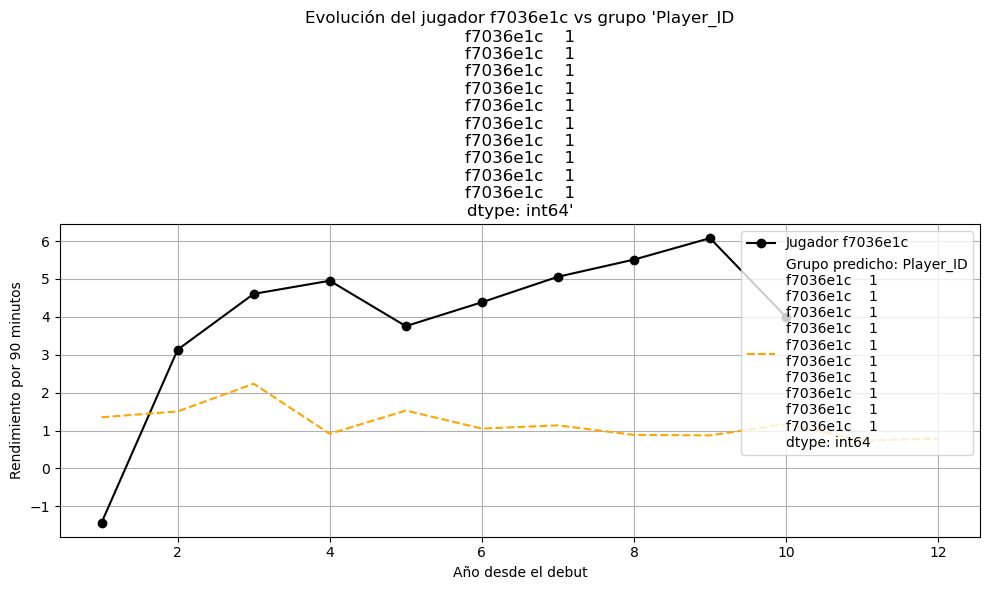

❌ El modelo se equivocó.


In [53]:
import matplotlib.pyplot as plt

# Asegurar que las predicciones tienen el índice correcto
y_test_named = pd.Series(y_test.values, index=test_df['Player_ID'])
y_pred_named = pd.Series(y_pred, index=test_df['Player_ID'])


# ID del jugador que queremos analizar
player_id = 'f7036e1c' # Lautaro Martínez

# Verificar si el jugador está en el test
if player_id not in y_test_named.index:
    print(f"⚠️ El jugador {player_id} no está en el conjunto de test. Prueba con uno de estos IDs:")
    print(y_test_named.index.tolist()[:10])
else:
    # Obtener clases real y predicha
    real_group = y_test_named.loc[player_id]
    pred_group = y_pred_named.loc[player_id]

    # Datos de trayectoria del jugador
    player_data = career_with_peak[career_with_peak['Player_ID'] == player_id].sort_values('year_since_debut')

    # Curva promedio del grupo predicho
    # Asegurarse de que pred_group es un valor escalar (int o str)
    pred_value = pred_group.iloc[0] if hasattr(pred_group, 'iloc') else pred_group
    group_data = career_with_peak[career_with_peak['target'] == pred_value]
    group_curve = (
        group_data.groupby('year_since_debut')['rating_per_90']
        .mean()
        .reset_index()
    )

    # Visualización
    plt.figure(figsize=(10, 6))
    plt.plot(player_data['year_since_debut'], player_data['rating_per_90'],
             marker='o', color='black', label=f'Jugador {player_id}')
    plt.plot(group_curve['year_since_debut'], group_curve['rating_per_90'],
             linestyle='--', color='orange', label=f'Grupo predicho: {pred_group}')

    plt.xlabel("Año desde el debut")
    plt.ylabel("Rendimiento por 90 minutos")
    plt.title(f"Evolución del jugador {player_id} vs grupo '{pred_group}'")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Texto de validación
    real_value = real_group.iloc[0] if hasattr(real_group, 'iloc') else real_group
    if real_value == pred_value:
        print("✅ El modelo acertó.")
    else:
        print("❌ El modelo se equivocó.")


